In [7]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from glob import glob
import matplotlib.pyplot as plt
import numpy as np


### 0. Notes on the data types

In [8]:
test1 = fits.getdata('/Users/peter/Downloads/hob/Ｍ22/-10 deg/Dark/20230403_Dark_1min-001.fit')
#test2 = fits.getdata('obsastro/HW5_CCD_files/Flat_V-2.fit.gz')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/peter/Downloads/hob/Ｍ22/-10 deg/Dark/20230403_Dark_1min-001.fit'

In [3]:
test1

array([[512, 520, 514, ..., 511, 514, 514],
       [516, 508, 508, ..., 514, 512, 517],
       [516, 514, 510, ..., 513, 512, 511],
       ...,
       [514, 514, 515, ..., 513, 518, 507],
       [510, 510, 507, ..., 511, 507, 510],
       [510, 510, 511, ..., 513, 514, 511]], dtype=uint16)

#### The data type of this array is uint16, which only allows values from 0 to 65535.

In [ ]:
test2

In [16]:
test1 + test2

NameError: name 'test2' is not defined

In [ ]:
test1[0][0] + test2[0][0]

In [ ]:
40007 + 39678

#### You can see that the output of `test1 + test2` is not what you would expect to see due to the overflow.

#### The way to solve this is to (1) convert to float32 or float64, or (2) use numpy functions.

In [ ]:
test1.astype(np.float64) + test2

In [ ]:
np.nansum([test1, test2], axis=0)

In [ ]:
np.nanmean([test1, test2], axis=0)

In [ ]:
np.nanmean([test1, test2], axis=0).dtype

### 1. Make master bias

In [9]:
# Find out the files using wildcards
bias_files = sorted(glob('/Users/peter/Desktop/Bias_-15/20230915_Bias-*.fit'))

In [10]:
bias_files[:36]

['/Users/peter/Desktop/Bias_-15/20230915_Bias-001.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-002.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-003.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-004.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-005.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-006.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-007.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-008.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-009.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-010.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-011.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-012.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-013.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-014.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-015.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-016.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-017.fit',
 '/Users/peter/Desktop/Bias_-15/20230915_Bias-01

In [11]:
# Read files
# astropy can read gzipped fits files
bias_data = [fits.getdata(file) for file in bias_files]

In [12]:
# Average the bias images
# Use np.nanmean instead of np.mean in case there are NaNs
master_bias = fits.getdata('/Users/peter/Downloads/hob/Ｍ22/-10 deg/bias_-10deg/Bias_stacked.fit')
#master_bias = np.nanmean(bias_data, axis=0)

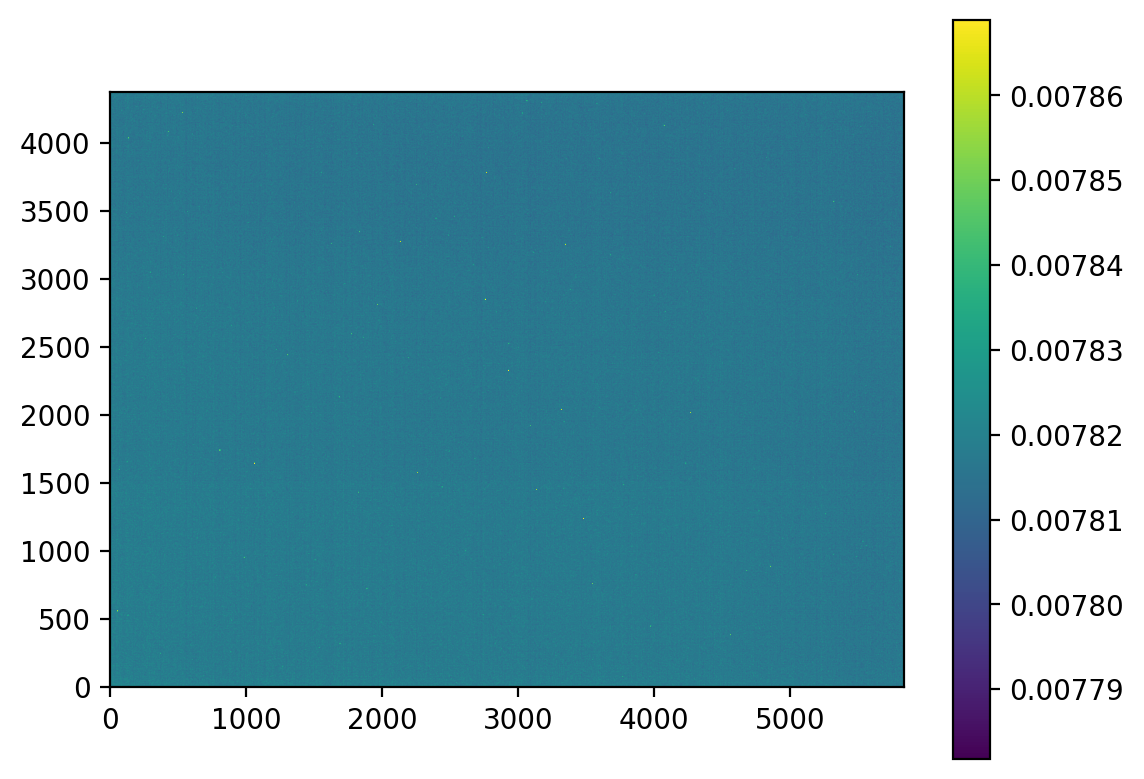

In [13]:
vmin, vmax = ZScaleInterval().get_limits(master_bias)
plt.figure(dpi=200)
plt.imshow(master_bias, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [14]:
fits.writeto('15_master_bias.fits', master_bias, overwrite=True)

### 2. Make master dark

In [15]:
# We can make this kind of repetitive work into a function
def get_average_images(files):
    data = [fits.getdata(file, ignore_missing_simple=True) for file in files]
    image = np.nanmean(data, axis=0)
    return image

def plot_image(data):
    vmin, vmax = ZScaleInterval().get_limits(data)
    plt.figure(dpi=200)
    plt.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

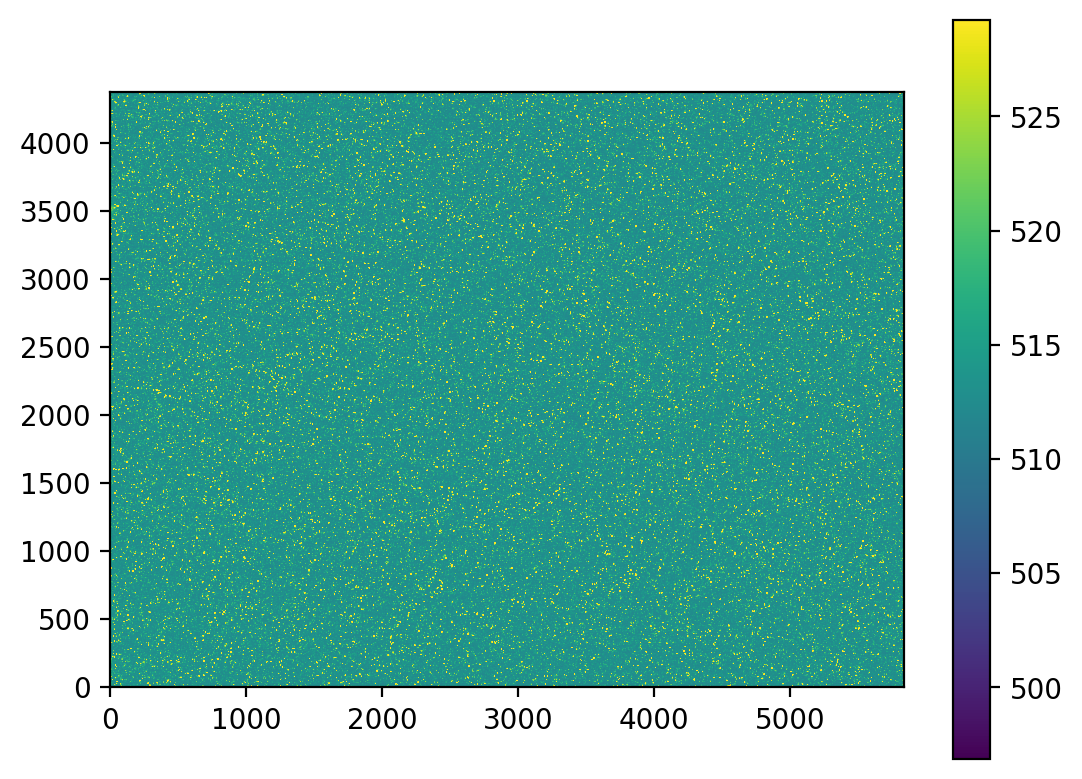

In [16]:
dark_files = sorted(glob('/Users/peter/Desktop/Dark_8min-10/20230403_Dark_8min-001.fit'),
                    key=lambda x: int(x.split('-')[-1].split('.')[0]))
if not dark_files:
    print("No dark frames found.")
else:
    try:
        master_dark = get_average_images(dark_files)
        plot_image(master_dark)
    except Exception as e:
        print(f"Error processing dark frames: {e}")
        print("Problematic file:", dark_files[np.argmax([fits.is_fits(file) for file in dark_files])])

In [43]:
#master_dark = get_average_images(dark_files)

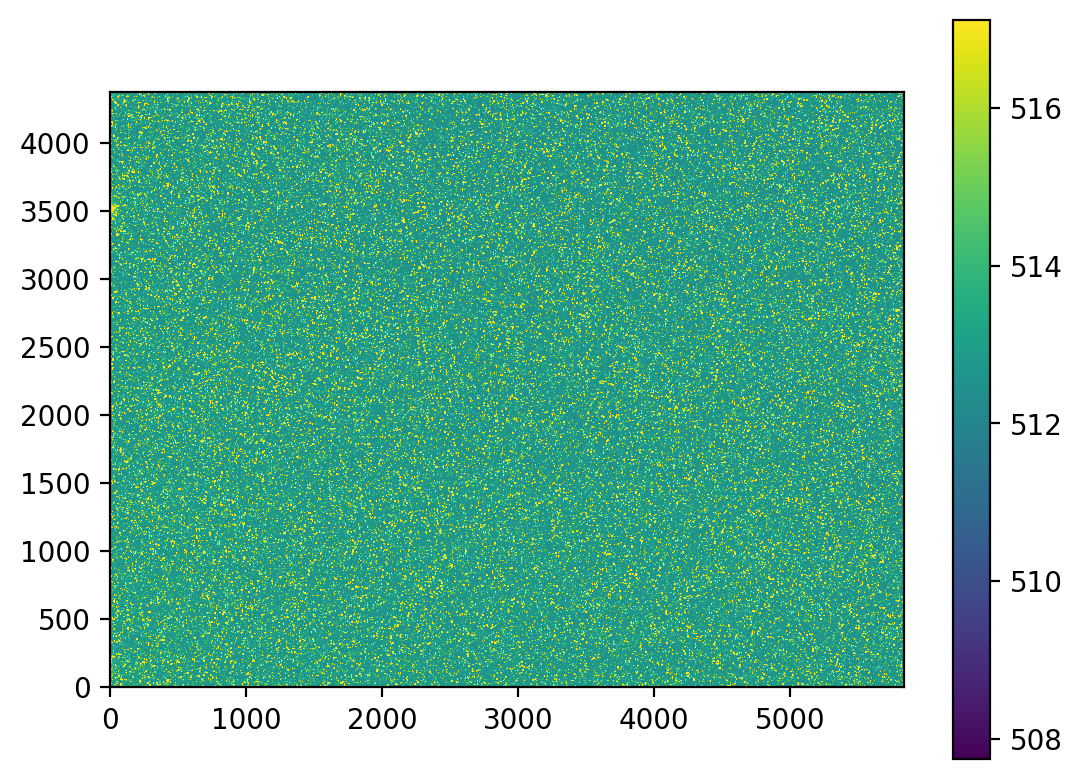

In [44]:
#plot_image(master_dark)
#plt.show()

In [19]:
# Subtract master bias from master dark
master_dark -= master_bias

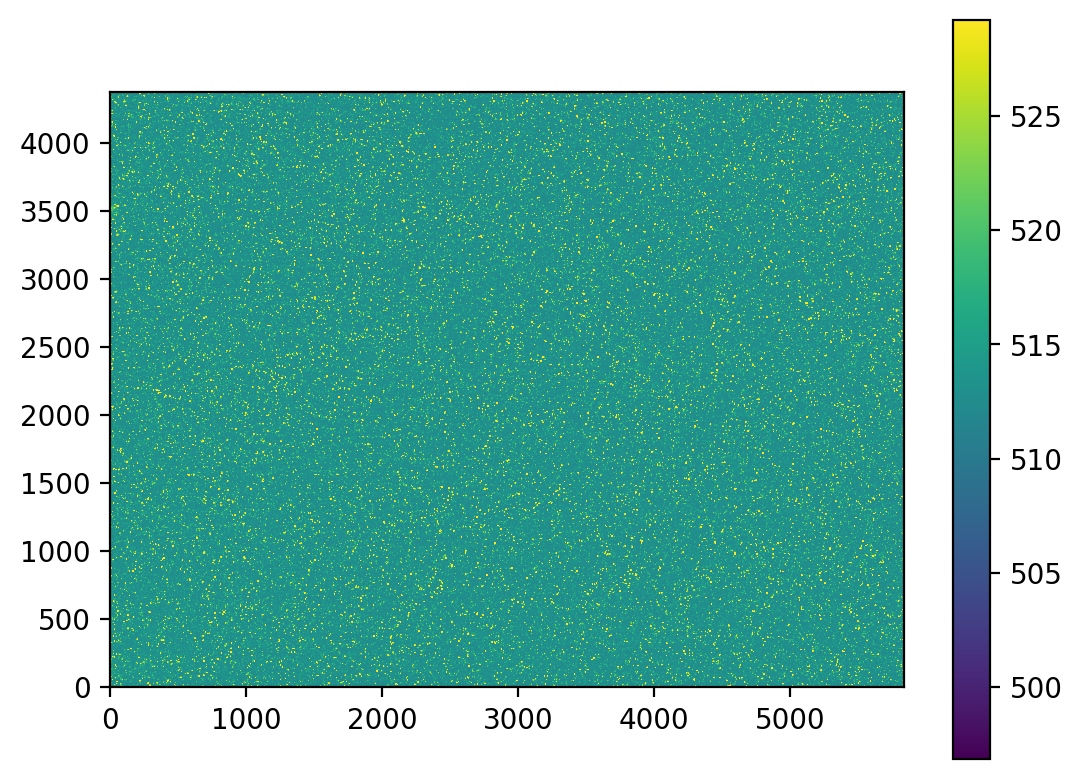

In [20]:
plot_image(master_dark)
plt.show()

In [21]:
fits.writeto('10_8min_master_dark.fits', master_dark, overwrite=True)

### 3. Make master flat

In [ ]:
#flat_files = sorted(glob('obsastro/HW5_CCD_files/Flat*.fit.gz'))

In [22]:
#master_flat = get_average_images(flat_files)
master_flat = fits.getdata('/Users/peter/Downloads/hob/Ｍ22/Flat/M22_flat_B_stacked.fit')

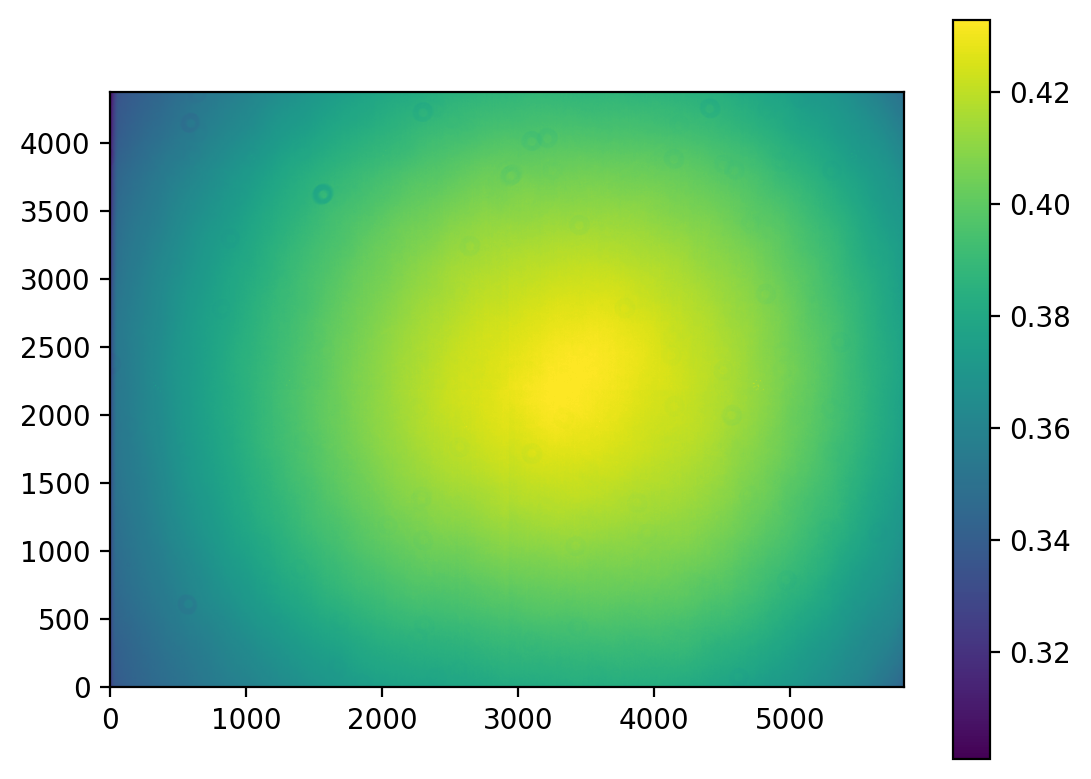

In [23]:
plot_image(master_flat)
plt.show()

In [24]:
# Subtract master bias
master_flat -= master_bias
# Normalize the mean value to one
master_flat = master_flat / np.nanmean(master_flat)

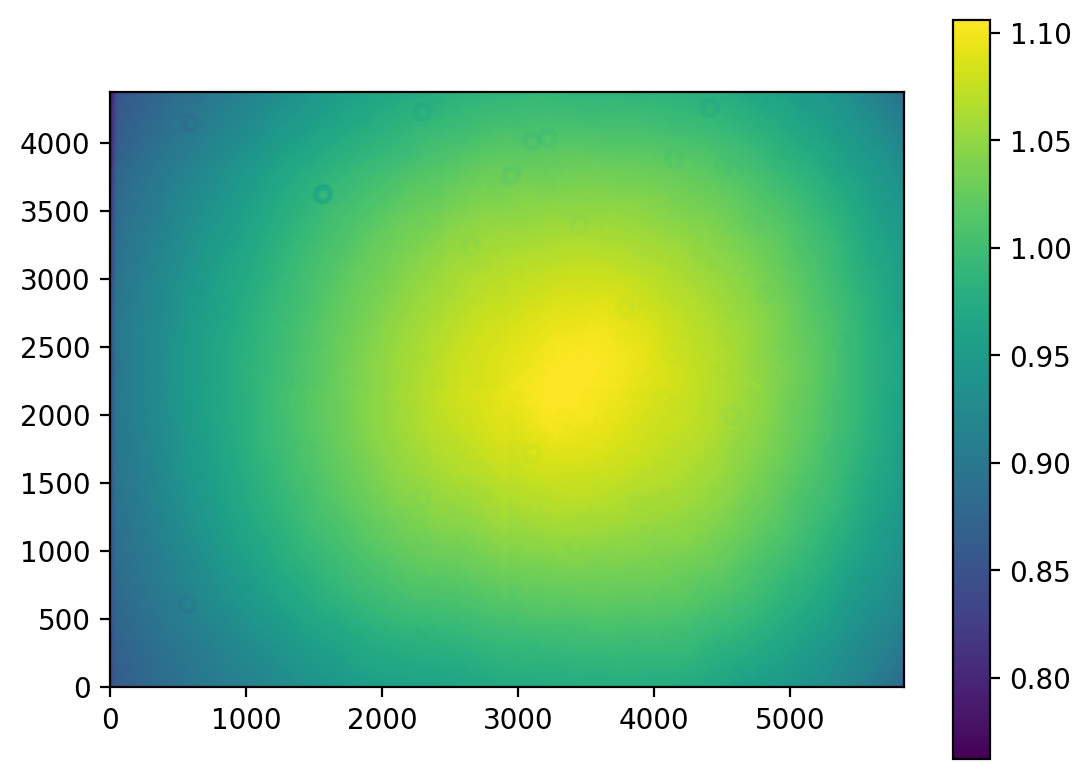

In [25]:
plot_image(master_flat)

In [26]:
fits.writeto('B_master_flat.fits', master_flat, overwrite=True)

### 4. Calibrate the science image

In [28]:
import os
import re
from astropy.io import fits

def get_calibration_files(temp, filter_type, exptime):
    flat_prefix = "/Users/peter/Documents/final_hob/M22_flat"
    bias_prefix = f"/Users/peter/Documents/final_hob/{temp}_master_bias"
    dark_prefix = f"/Users/peter/Documents/final_hob/{temp}_{exptime}sec_master_dark"

    if filter_type == "B":
        flat_suffix = "_B_stacked.fit"
    else:
        flat_suffix = "_V_stacked.fit"

    flat_file = flat_prefix + flat_suffix
    bias_file = bias_prefix + ".fits"
    dark_file = dark_prefix + ".fits"

    return flat_file, bias_file, dark_file

exposure_times = [1, 5, 30, 300, 480]

sci_files = [
    #"/Users/peter/Documents/final_hob/r_M22_B_8min_stacked.fit",
    # "/Users/peter/Documents/final_hob/r_M22_B_30sec_stacked.fit",
    # "/Users/peter/Documents/final_hob/r_M22_V_5min_stacked.fit",
    # "/Users/peter/Documents/final_hob/r_M22_V_5sec_stacked.fit",
    # "/Users/peter/Documents/final_hob/r_M22_V_30sec_stacked.fit",
    "/Users/peter/Documents/final_hob/r_M22_R_5min_stacked.fit"
]

# Define a regular expression pattern to capture temperature and exposure time
pattern = re.compile(r'(-?\d+)_?(\d+)(?:sec|min)_')

for sci_file in sci_files:
    hdu = fits.open(sci_file)
    sci = hdu[0].data
    hdr = hdu[0].header
    exptime = hdr['EXPTIME']
    filter_type = sci_file.split('_')[3]  # Assuming filter type is at index 3 in the file name

    # Search for the temperature and exposure time pattern in the file name
    match = pattern.search(sci_file)
    
    if not match:
        raise ValueError(f"Temperature and/or exposure time information not found in the file name: {sci_file}")

    temp, exptime_str = match.groups()
    temp = 15
    exptime = int(exptime_str)

    # Check if the exposure time is valid
    if exptime not in exposure_times:
        raise ValueError(f"Invalid exposure time: {exptime}")

    flat, bias, dark = get_calibration_files(temp, filter_type, exptime)

    # Check if calibration files exist before proceeding
    for file in [flat, bias, dark]:
        if not os.path.exists(file):
            raise FileNotFoundError(f"Calibration file {file} not found.")

    calibrated_sci = ((sci - fits.getdata(bias) - fits.getdata(dark)) / exptime) / fits.getdata(flat)

    output_file = f"calibrated_temp{temp}_" + os.path.basename(sci_file)
    fits.writeto(output_file, calibrated_sci, overwrite=True)


ValueError: Temperature and/or exposure time information not found in the file name: /Users/peter/Documents/final_hob/r_M22_B_8min_stacked.fit

In [111]:
sci_files = sorted(glob('r_*.fit'))
print(sci_files)
# sci_data = [fits.getdata(file) for file in sci_files]
for i in range(len(sci_files)):
    hdu = fits.open(sci_files[i])
    sci = hdu[0].data
    hdr = hdu[0].header
    exptime = hdr['EXPTIME']

    if sci_files[i].split('_')[2]=="B":
        flat = fits.getdata("master_Flat_B_stacked.fit")
    else:
        flat = fits.getdata("master_Flat_V_stacked.fit")

    if sci_files[i].split('_')[1]=="M22":
        bias = fits.getdata("Bias-15_stacked.fits")
        if exptime==1:
            dark = fits.getdata("master_Dark_1sec-15_stacked.fits")
        #elif exptime==5:
            #dark = fits.getdata("master_Dark_5sec-15_stacked.fits")
        elif exptime==30:
            dark = fits.getdata("master_Dark_30sec-15_stacked.fits")
        elif exptime==300:
            dark = fits.getdata("master_Dark_5min-15_stacked.fits")
        elif exptime==480:
            dark = fits.getdata("master_Dark_8min-15_stacked.fits")
    else:
        bias = fits.getdata("Bias-10_stacked.fits")
        if exptime==1:
            dark = fits.getdata("master_Dark_1sec-10_stacked.fit")
        elif exptime==5:
            dark = fits.getdata("master_Dark_5sec-10_stacked.fit")
        elif exptime==30:
            dark = fits.getdata("master_Dark_30sec-10_stacked.fit")
        elif exptime==300:
            dark = fits.getdata("master_Dark_5min-10_stacked.fit")
        elif exptime==480:
            dark = fits.getdata("master_Dark_8min-10_stacked.fit")

    calibrated_sci = ((sci - bias - dark) / exptime) / flat     

    fits.writeto("calibrated_"+sci_files[i], sci, overwrite=True)

['r_M22_B_30sec_stacked.fit', 'r_M22_B_8min_stacked.fit', 'r_M22_V_30sec_stacked.fit', 'r_M22_V_5min_stacked.fit', 'r_M22_V_5sec_stacked.fit']


In [ ]:
sci = hdu[0].data
hdr = hdu[0].header

In [ ]:
# Unit: second
exptime = hdr['EXPTIME']
exptime

In [ ]:
# Original image
plot_image(sci)

In [ ]:
calibrated_sci = ((sci - master_bias - master_dark) / exptime) / master_flat

In [ ]:
# Calibrated image
plot_image(calibrated_sci)

In [ ]:
# Calibrated image (zoom in)
plot_image(calibrated_sci[1000:1200, 1000:1200])

In [ ]:
plt.hist(calibrated_sci.ravel(), bins=100)
plt.yscale('log')
plt.xlabel(r'ADU $\rm s^{-1}$')
plt.ylabel('#')
plt.show()

In [ ]:
fits.writeto('M39_V_1min-1_calibrated.fit', calibrated_sci, overwrite=True)